# Sentiment Analysis 

**Libraries**

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
import warnings 

warnings.filterwarnings('ignore')
plt.style.use('ggplot')


## Read data

In [2]:
df = pd.read_csv('Reviews.csv')

In [3]:
df = df.head(250)
df.shape

(250, 10)

In [4]:
df.head(2)

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...


## EDA

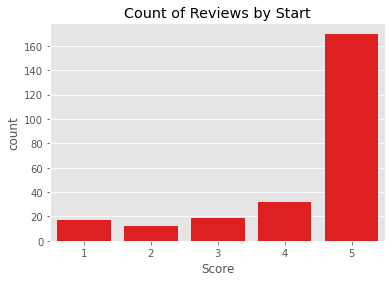

In [5]:
sns.countplot(df['Score'], color = 'red')
plt.title('Count of Reviews by Start')
plt.show()

#### Basic NLKT

In [6]:
ex = df['Text'][50]
print(ex)

This oatmeal is not good. Its mushy, soft, I don't like it. Quaker Oats is the way to go.


In [7]:
tokens =  nltk.word_tokenize(ex)
tokens[:10]

['This', 'oatmeal', 'is', 'not', 'good', '.', 'Its', 'mushy', ',', 'soft']

In [8]:
tagged = nltk.pos_tag(tokens)
tagged[:10]

[('This', 'DT'),
 ('oatmeal', 'NN'),
 ('is', 'VBZ'),
 ('not', 'RB'),
 ('good', 'JJ'),
 ('.', '.'),
 ('Its', 'PRP$'),
 ('mushy', 'NN'),
 (',', ','),
 ('soft', 'JJ')]

# Step 1. VADER Sentiment scoring
- remove stop words
- each word is scored and combined a total score

In [9]:
from nltk.sentiment import SentimentIntensityAnalyzer

In [10]:
sia = SentimentIntensityAnalyzer()

In [11]:
sia.polarity_scores('I am so happy')

{'neg': 0.0, 'neu': 0.334, 'pos': 0.666, 'compound': 0.6115}

In [12]:
sia.polarity_scores(ex)

{'neg': 0.22, 'neu': 0.78, 'pos': 0.0, 'compound': -0.5448}

In [13]:
# run polarity score for entire dataset
res ={}
for i, row in df.iterrows():
    text = row['Text']
    myid = row['Id']
    res[myid] = sia.polarity_scores(text)

In [14]:
vaders =  pd.DataFrame(res).T
vaders = vaders.reset_index().rename(columns= {'index':"Id" })
vaders = vaders.merge(df, how= 'left')

In [15]:
vaders.head()

,Id,neg,neu,pos,compound,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,0.000,0.695,0.305,0.9441,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,0.138,0.862,0.000,-0.5664,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,0.091,0.754,0.155,0.8265,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,0.000,1.000,0.000,0.0000,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,0.000,0.552,0.448,0.9468,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


In [16]:
vaders.iloc[50]

Id                                                                       51
neg                                                                    0.22
neu                                                                    0.78
pos                                                                     0.0
compound                                                            -0.5448
ProductId                                                        B001EO5QW8
UserId                                                       A108P30XVUFKXY
ProfileName                                                       Roberto A
HelpfulnessNumerator                                                      0
HelpfulnessDenominator                                                    7
Score                                                                     1
Time                                                             1203379200
Summary                                                       Don't like it
Text        

### Plot VAder Results

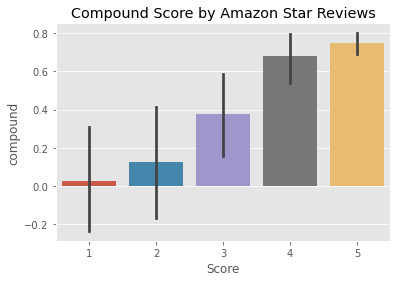

In [17]:
sns.barplot(x = vaders['Score'], y  = vaders['compound'])
plt.title('Compound Score by Amazon Star Reviews')
plt.show()

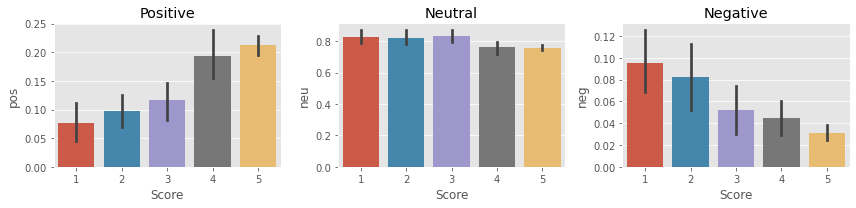

In [18]:
fig, axs = plt.subplots(1,3, figsize = (12,3))

sns.barplot(data = vaders, x = "Score", y = 'pos', ax = axs[0])
sns.barplot(data = vaders, x = "Score", y = 'neu', ax = axs[1])
sns.barplot(data = vaders, x = "Score", y = 'neg', ax = axs[2])


axs[0].set_title("Positive")
axs[1].set_title("Neutral")
axs[2].set_title("Negative")

plt.tight_layout()
plt.show()

#### Step 3. Roberta Pretraned Model

In [19]:
from transformers import AutoTokenizer
from transformers import AutoModelForSequenceClassification
from scipy.special import softmax

In [21]:
MODEL = f"cardiffnlp/twitter-roberta-base-sentiment"
tokenizer = AutoTokenizer.from_pretrained(MODEL)
model = AutoModelForSequenceClassification.from_pretrained(MODEL)

Downloading:   0%|          | 0.00/747 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/878k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/446k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/150 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/476M [00:00<?, ?B/s]

In [22]:
#VADER result on sample
sia.polarity_scores(ex)

{'neg': 0.22, 'neu': 0.78, 'pos': 0.0, 'compound': -0.5448}

In [24]:
#run Roberta Model

encoded_text = tokenizer(ex, return_tensors= 'pt')
output = model(**encoded_text)
scores = output[0][0].detach().numpy()
scores = softmax(scores)

scores_dict ={
    
    'roberta_neg': scores[0], 
    'roberta_neu': scores[1],
    'roberta_pos': scores[2]
}

scores_dict

{'roberta_neg': 0.97635514,
 'roberta_neu': 0.020687452,
 'roberta_pos': 0.0029573687}

In [25]:
#make functions

def polarity_scores_roberta(example):
    encoded_text = tokenizer(ex, return_tensors= 'pt')
    output = model(**encoded_text)
    scores = output[0][0].detach().numpy()
    scores = softmax(scores)

    scores_dict ={
    
    'roberta_neg': scores[0], 
    'roberta_neu': scores[1],
    'roberta_pos': scores[2]
            }

    return scores_dict

In [27]:
res = {}
for i, row in df.iterrows():
    try:
        text = row['Text']
        myid = row['Id']
        vader_result = sia.polarity_scores(text)
        vader_result_rename = {}
        for key, value in vader_result.items():
            vader_result_rename[f"vader_{key}"] = value
        roberta_result = polarity_scores_roberta(text)
        both = {**vader_result_rename, **roberta_result}
        res[myid] = both
    except RuntimeError:
        print(f'Broke for id {myid}')

In [28]:
results_df = pd.DataFrame(res).T
results_df = results_df.reset_index().rename(columns={'index': 'Id'})
results_df = results_df.merge(df, how='left')

In [29]:
results_df.columns

Index(['Id', 'vader_neg', 'vader_neu', 'vader_pos', 'vader_compound',
       'roberta_neg', 'roberta_neu', 'roberta_pos', 'ProductId', 'UserId',
       'ProfileName', 'HelpfulnessNumerator', 'HelpfulnessDenominator',
       'Score', 'Time', 'Summary', 'Text'],
      dtype='object')

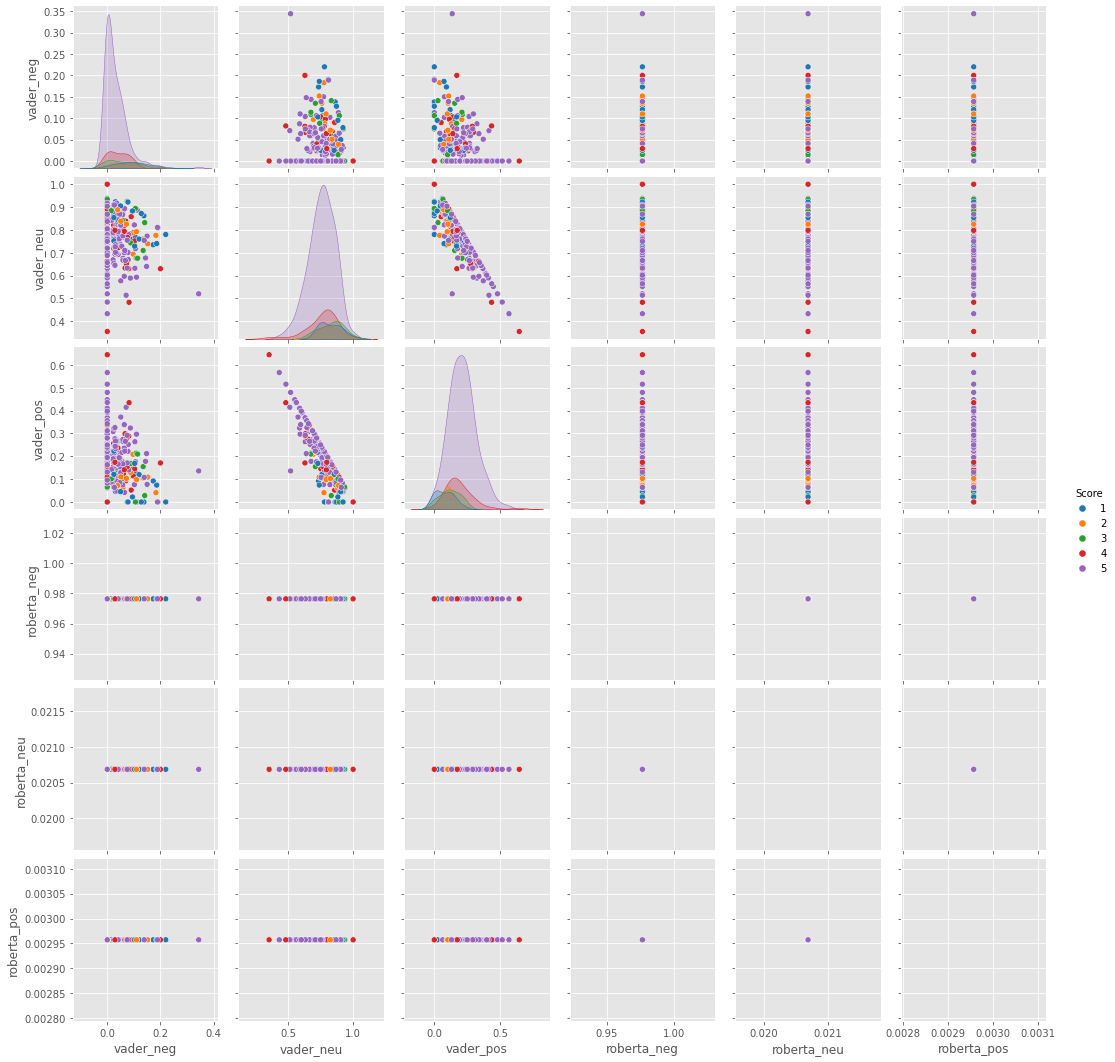

In [30]:
sns.pairplot(data=results_df,
             vars=['vader_neg', 'vader_neu', 'vader_pos',
                  'roberta_neg', 'roberta_neu', 'roberta_pos'],
            hue='Score',
            palette='tab10')
plt.show()

In [31]:
results_df.query('Score == 1') \
    .sort_values('roberta_pos', ascending=False)['Text'].values[0]

'Product arrived labeled as Jumbo Salted Peanuts...the peanuts were actually small sized unsalted. Not sure if this was an error or if the vendor intended to represent the product as "Jumbo".'

In [32]:
results_df.query('Score == 1') \
    .sort_values('vader_pos', ascending=False)['Text'].values[0]

'Seriously this product was as tasteless as they come. There are much better tasting products out there but at 100 calories its better than a special k bar or cookie snack pack. You just have to season it or combine it with something else to share the flavor.'

In [34]:
results_df.query('Score == 5') \
    .sort_values('roberta_neg', ascending=False)['Text'].values[0]

'I have bought several of the Vitality canned dog food products and have found them all to be of good quality. The product looks more like a stew than a processed meat and it smells better. My Labrador is finicky and she appreciates this product better than  most.'

In [35]:
results_df.query('Score == 5') \
    .sort_values('vader_neg', ascending=False)['Text'].values[0]

'this was sooooo deliscious but too bad i ate em too fast and gained 2 pds! my fault'

In [36]:
from transformers import pipeline

sent_pipeline = pipeline("sentiment-analysis")

No model was supplied, defaulted to distilbert-base-uncased-finetuned-sst-2-english (https://huggingface.co/distilbert-base-uncased-finetuned-sst-2-english)


Downloading:   0%|          | 0.00/629 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/255M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

In [37]:
sent_pipeline('I love sentiment analysis!')

[{'label': 'POSITIVE', 'score': 0.9997853636741638}]

In [39]:
sent_pipeline('this was sooooo deliscious but too bad i ate em too fast and gained 2 pds! my fault')

[{'label': 'NEGATIVE', 'score': 0.9980344176292419}]